# libraries

In [1]:
# data processing
import torch
import numpy as np

# signal processing
from torch.fft import fft, ifft

# visualization
import matplotlib.pyplot as plt

# utils
from numbers import Real
from torch.nn.functional import pad, one_hot
from typing import Callable

# data

In [2]:
fs = 200
n_channels = 65

In [3]:
data_Dinh = torch.load('data/data_Dinh_fs200.pt')
data_Heitmann = torch.load('data/data_Heitmann_fs200.pt')
eeg_data = torch.cat((data_Dinh, data_Heitmann))
eeg_data.shape

torch.Size([230, 65, 55000])

In [4]:
labels_Dinh = torch.load('data/labels_Dinh_fs200.pt')
labels_Heitmann = torch.load('data/labels_Heitmann_fs200.pt')
eeg_labels = torch.cat((labels_Dinh, labels_Heitmann))
eeg_labels.shape

torch.Size([230])

In [5]:
def plot_eeg_data(patient, channels):
    assert isinstance(channels, list)
    total_channels = len(channels)
    fig, axs = plt.subplots(total_channels, sharex=True, figsize=(20, total_channels))
    if total_channels == 1:
        axs.plot(eeg_data[patient][channels[0],:])
    else:
        for i in range(total_channels):
            axs[i].plot(eeg_data[patient][channels[i],:])
            axs[i].set_ylabel(f'EEG {channels[i]}')

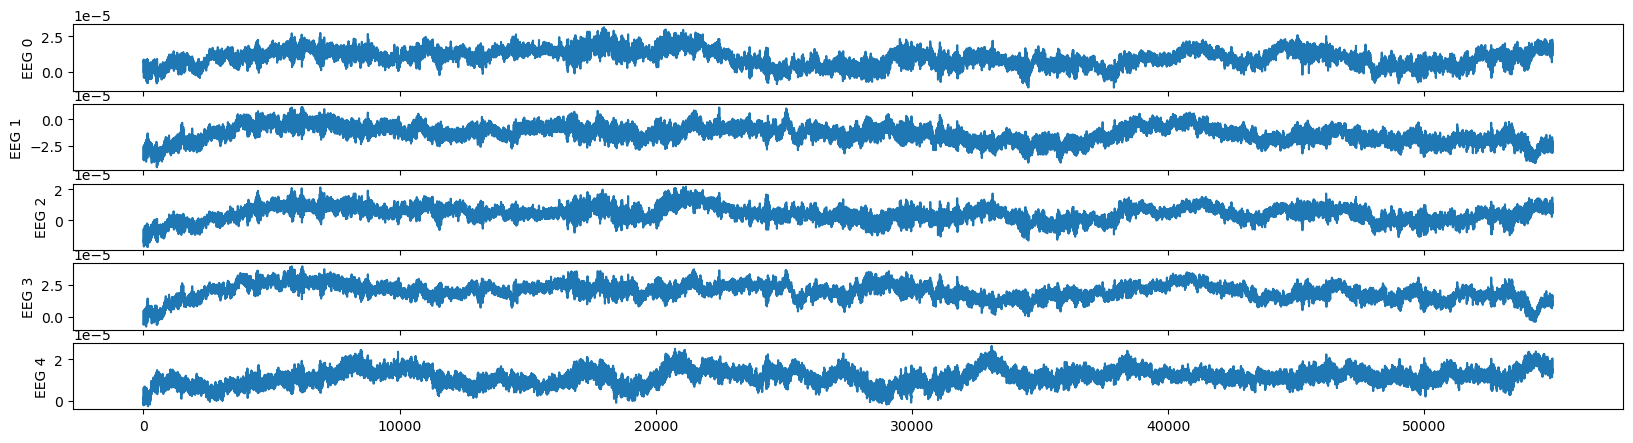

In [6]:
patient = 30
channels = list(range(0, 5))
plot_eeg_data(patient, channels)

In [7]:
signal = eeg_data[30][0,:]
signal.shape

torch.Size([55000])

# Signal Transformations 

## Gaussian Noise

In [8]:
N = signal.shape[0]
mu = 0
sigma = 2e-6

In [9]:
noise = torch.normal(
    mean=torch.full((1, N), mu, dtype=torch.float16), 
    std=torch.full((1, N), sigma, dtype=torch.float16)
)

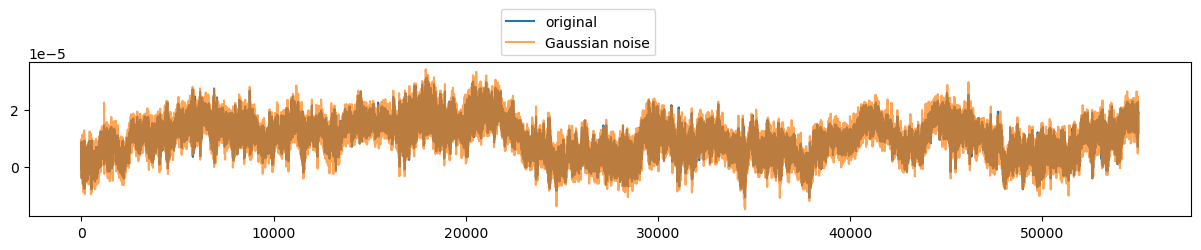

In [10]:
signal_modified = signal + noise[0]

plt.figure(figsize=(15, 2))
plt.plot(signal)
plt.plot(signal_modified, alpha=0.7)
plt.legend(['original', 'Gaussian noise'], bbox_to_anchor=(0.4, 1))

In [11]:
signal.size()

torch.Size([55000])

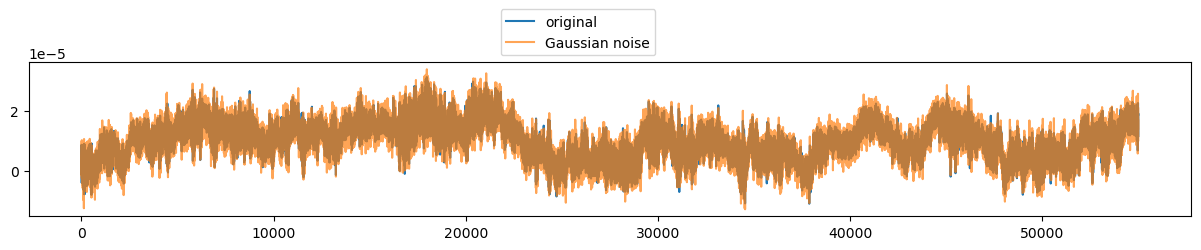

In [12]:
signal_modified = signal + torch.randn(signal.size()) * sigma + mu
plt.figure(figsize=(15, 2))
plt.plot(signal)
plt.plot(signal_modified, alpha=0.7)
plt.legend(['original', 'Gaussian noise'], bbox_to_anchor=(0.4, 1))

## Sign Flip

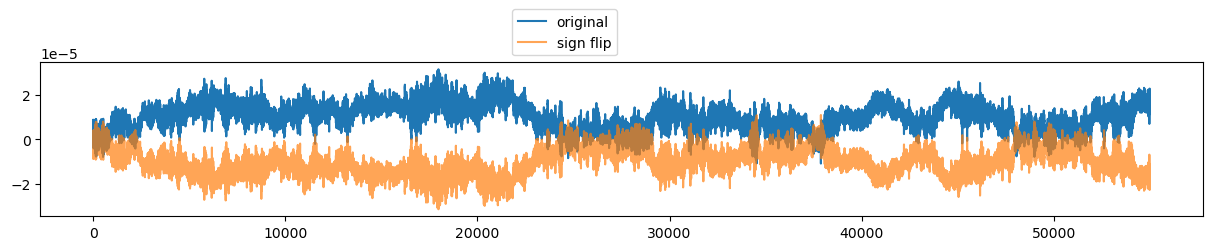

In [13]:
signal_modified = -signal

plt.figure(figsize=(15, 2))
plt.plot(signal)
plt.plot(signal_modified, alpha=0.7)
plt.legend(['original', 'sign flip'], bbox_to_anchor=(0.4, 1))

## Time Flip

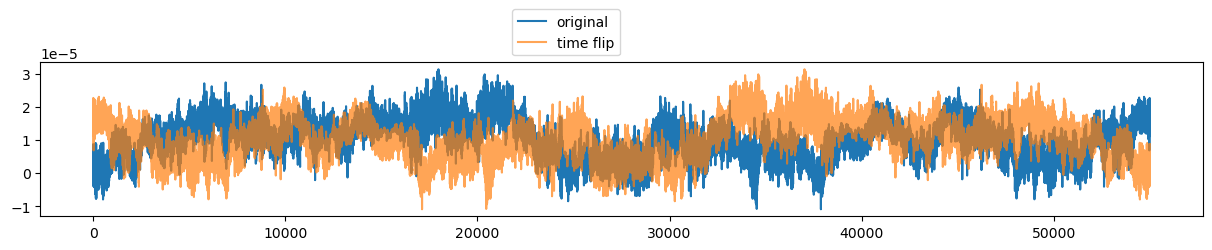

In [14]:
signal_modified = signal.unsqueeze(0).flip(-1).squeeze()

plt.figure(figsize=(15, 2))
plt.plot(signal)
plt.plot(signal_modified, alpha=0.7)
plt.legend(['original', 'time flip'], bbox_to_anchor=(0.4, 1))

## Random Rescale

In [15]:
mu = 1
sigma = 0.1
rescaling_factor = torch.normal(
    mean=torch.Tensor([mu]), 
    std=torch.Tensor([sigma])
)
rescaling_factor

tensor([1.0200])

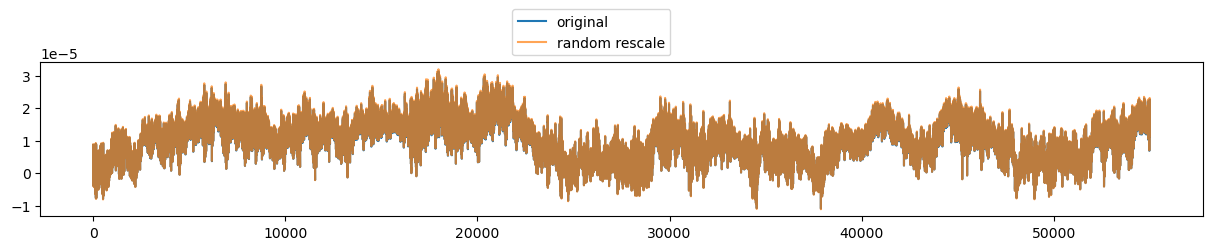

In [16]:
signal_modified = signal * rescaling_factor

plt.figure(figsize=(15, 2))
plt.plot(signal)
plt.plot(signal_modified, alpha=0.7)
plt.legend(['original', 'random rescale'], bbox_to_anchor=(0.4, 1))

## Fourier Transform Surrogate

Fourier surrogates (FS) Fourier surrogates are a form of constrained surrogates created by taking the Fourier transform of a time series, then shuffling either the phase angles or the amplitudes of the resulting complex numbers. Then, we take the inverse Fourier transform, yielding a surrogate time series.

In [17]:
signal = eeg_data[30][0,:]
signal.shape

torch.Size([55000])

In [18]:
"""
Float between 0 and 1 setting the range over which the phase pertubation is uniformly sampled:
[0, `phase_noise_magnitude` * 2 * `pi`].
"""        
phase_noise_magnitude=0.5

In [19]:
#https://stats.stackexchange.com/questions/204032/surrogate-time-series-using-fourier-transform
#https://stackoverflow.com/questions/72716727/surrogate-time-series-using-np-fft-rfft-results-into-typeerror
 # FFT of time-series
ts_fourier  = np.fft.rfft(signal)
 # Generate random phases
random_phases = np.exp(np.random.uniform(0,phase_noise_magnitude*np.pi,N//2+1)*1.0j)
# Randomize the phases in the FFT
ts_fourier_new = ts_fourier * random_phases
# Tranforms the frequency-domain back into the time-domain = Surrogate time-series
signal_modified = np.fft.irfft(ts_fourier_new)

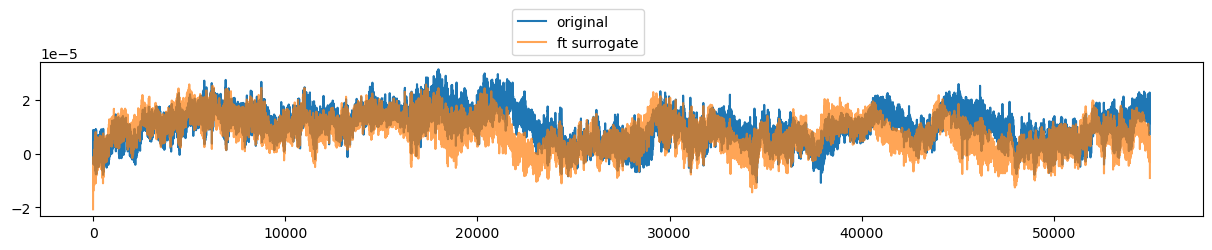

In [20]:
plt.figure(figsize=(15, 2))
plt.plot(signal)
plt.plot(signal_modified, alpha=0.7)
plt.legend(['original', 'ft surrogate'], bbox_to_anchor=(0.4, 1))

## Frequency Shift

In [21]:
signal = eeg_data[30][0,:]
signal.shape

torch.Size([55000])

In [22]:
# The amplitude of the frequency shift (in Hz).
delta_freq = 0.001
# Sampling frequency of the signals to be transformed.
sfreq = 200

In [23]:
def nextpow2(n):
    """Return the first integer N such that 2**N >= abs(n)."""
    return int(np.ceil(np.log2(np.abs(n))))

def analytic_transform(x):
    N = x.shape[-1]
    f = fft(x, N, dim=-1)
    h = torch.zeros_like(f)
    if N % 2 == 0:
        h[..., 0] = h[..., N // 2] = 1
        h[..., 1:N // 2] = 2
    else:
        h[..., 0] = 1
        h[..., 1:(N + 1) // 2] = 2

    return ifft(f * h, dim=-1)

def frequency_shift(X, fs, f_shift):
    """
    Shift the specified signal by the specified frequency.

    See https://gist.github.com/lebedov/4428122
    
    X : torch.Tensor - [channels, eeg]
    """
    # Pad the signal with zeros to prevent the FFT invoked by the transform
    # from slowing down the computation:
    n_channels, N_orig = X.shape[-2:]
    N_padded = 2 ** nextpow2(N_orig)
    t = torch.arange(N_padded, device=X.device) / fs
    padded = pad(X, (0, N_padded - N_orig))
    analytical = analytic_transform(padded)
    if isinstance(f_shift, (float, int, np.ndarray, list)):
        f_shift = torch.as_tensor(f_shift).float()
    reshaped_f_shift = f_shift.repeat(N_padded, n_channels, 1).T
    shifted = analytical * torch.exp(2j * np.pi * reshaped_f_shift * t)

    return shifted[..., :N_orig].real.float()

/var/folders/6b/k6pplq_d3xq67frlxzbtwbtw0000gn/T/ipykernel_74887/2366189783.py:35: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817727684/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  reshaped_f_shift = f_shift.repeat(N_padded, n_channels, 1).T


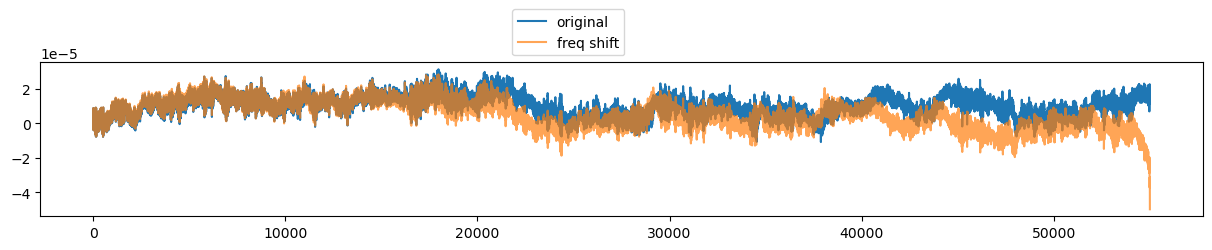

In [24]:
signal_modified = frequency_shift(signal.unsqueeze(0), sfreq, delta_freq).squeeze()
plt.figure(figsize=(15, 2))
plt.plot(signal)
plt.plot(signal_modified, alpha=0.7)
plt.legend(['original', 'freq shift'], bbox_to_anchor=(0.4, 1))

## Normalization

In [25]:
signal = eeg_data[30][0,:]
signal.shape

torch.Size([55000])

In [26]:
np_signal = signal.detach().numpy()
mean = np.mean(np_signal)
std = np.std(np_signal)
print(mean, std)

9.9140225e-06 5.8854216e-06


In [27]:
signal_modified = (np_signal - mean) / std

In [28]:
np.mean(signal_modified), np.std(signal_modified)

(-5.7705964e-08, 1.0)

Text(0, 0.5, 'Normalized')

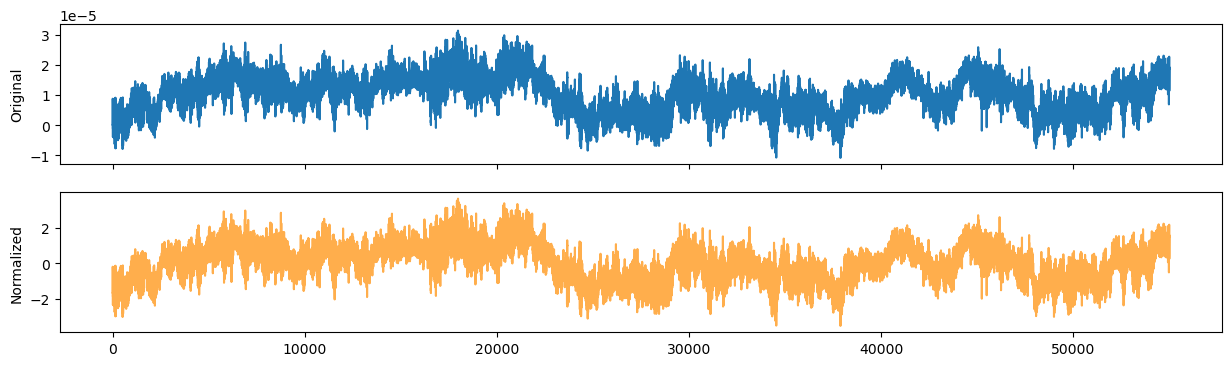

In [29]:
fig, axs = plt.subplots(2, sharex=True, figsize=(15, 4))
axs[0].plot(signal)
axs[0].set_ylabel('Original')

axs[1].plot(signal_modified, alpha=0.7, color='darkorange')
axs[1].set_ylabel('Normalized')

# EEG Data Augmentation

In [ ]:
def plot_eeg_transformations(eeg_original, eeg_modified, channels):
    assert isinstance(channels, list)
    total_channels = len(channels)
    fig, axs = plt.subplots(total_channels, sharex=True, figsize=(20, total_channels*1.1))
    if total_channels == 1:
        axs.plot(eeg_original[channels[0],:])
        axs.plot(eeg_modified[channels[0],:], alpha=0.7)
    else:
        for i in range(total_channels):
            axs[i].plot(eeg_original[channels[i],:])
            axs[i].plot(eeg_modified[channels[i],:], alpha=0.7)
            axs[i].set_ylabel(f'EEG {channels[i]}')

In [ ]:
eeg_signal = eeg_data[30]
channels = list(range(0, 5))
eeg_signal.shape

## Gaussian Noise

In [ ]:
class GaussianNoise(Callable):
    def __init__(self, mu, sigma, channel_prob):
        self.mu = mu
        self.sigma = sigma
        self.channel_prob = channel_prob

    def __call__(self, signal):
        if self.channel_prob > np.random.uniform():
            return signal + torch.randn(signal.size()) * self.sigma + self.mu
        else:
            return signal

In [ ]:
gaussian_transf = GaussianNoise(mu=0, sigma=2e-7, channel_prob=1)
eeg_signal_modified = gaussian_transf(eeg_signal)
plot_eeg_transformations(eeg_signal, eeg_signal_modified, channels)

In [ ]:
plt.figure(figsize=(15, 2))
plt.plot(eeg_signal[0])
plt.plot(eeg_signal_modified[0], alpha=0.7)
plt.legend(['original', 'Gaussian noise'], bbox_to_anchor=(0.4, 1))

## Sign Flip

In [ ]:
class SignFlip(Callable):
    def __init__(self, channel_prob):
        self.channel_prob = channel_prob

    def __call__(self, signal):
        if self.channel_prob > np.random.uniform():
            return -signal
        else:
            return signal

In [ ]:
sign_flip_transf = SignFlip(channel_prob=1)
eeg_signal_modified = sign_flip_transf(eeg_signal)
plot_eeg_transformations(eeg_signal, eeg_signal_modified, channels)

In [ ]:
plt.figure(figsize=(15, 2))
plt.plot(eeg_signal[0])
plt.plot(eeg_signal_modified[0], alpha=0.7)
plt.legend(['original', 'sign flip'], bbox_to_anchor=(0.4, 1))

## Time Flip

In [ ]:
class TimeFlip(Callable):
    def __init__(self, channel_prob):
        self.channel_prob = channel_prob

    def __call__(self, signal):
        if self.channel_prob > np.random.uniform():
            return torch.flip(signal, [1])
        else:
            return signal

In [ ]:
time_flip_transf = TimeFlip(channel_prob=1)
eeg_signal_modified = time_flip_transf(eeg_signal)
plot_eeg_transformations(eeg_signal, eeg_signal_modified, channels)

In [ ]:
plt.figure(figsize=(15, 2))
plt.plot(eeg_signal[0])
plt.plot(eeg_signal_modified[0], alpha=0.7)
plt.legend(['original', 'time flip'], bbox_to_anchor=(0.4, 1))

## Random Rescale

In [ ]:
class RandomRescale(Callable):
    def __init__(self, mu, sigma, channel_prob):
        self.mu = mu
        self.sigma = sigma
        self.channel_prob = channel_prob

    def __call__(self, signal):
        if self.channel_prob > np.random.uniform():
            rescaling = torch.normal(mean=torch.Tensor([self.mu]), std=torch.Tensor([self.sigma]))
            print(rescaling)
            return signal * rescaling
        else:
            return signal

In [ ]:
random_rescale_transf = RandomRescale(mu=1, sigma=1e-2, channel_prob=1)
eeg_signal_modified = random_rescale_transf(eeg_signal)
plot_eeg_transformations(eeg_signal, eeg_signal_modified, channels)

In [ ]:
plt.figure(figsize=(15, 2))
plt.plot(eeg_signal[0])
plt.plot(eeg_signal_modified[0], alpha=0.7)
plt.legend(['original', 'random rescale'], bbox_to_anchor=(0.4, 1))

## Fourier Transform Surrogate

In [ ]:
def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance.

    Parameters
    ----------
    seed : None, int or instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.

    Returns
    -------
    :class:`numpy:numpy.random.RandomState`
        The random state object based on `seed` parameter.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError(
        "%r cannot be used to seed a numpy.random.RandomState instance" % seed
    )
    
def _new_random_fft_phase_odd(batch_size, c, n, device, random_state):
    rng = check_random_state(random_state)
    random_phase = torch.from_numpy(
        2j * np.pi * rng.random((batch_size, c, (n - 1) // 2))
    ).to(device)
    return torch.cat([
        torch.zeros((batch_size, c, 1), device=device),
        random_phase,
        -torch.flip(random_phase, [-1])
    ], dim=-1)


def _new_random_fft_phase_even(batch_size, c, n, device, random_state):
    rng = check_random_state(random_state)
    random_phase = torch.from_numpy(
        2j * np.pi * rng.random((batch_size, c, n // 2 - 1))
    ).to(device)
    return torch.cat([
        torch.zeros((batch_size, c, 1), device=device),
        random_phase,
        torch.zeros((batch_size, c, 1), device=device),
        -torch.flip(random_phase, [-1])
    ], dim=-1)

_new_random_fft_phase = {
    0: _new_random_fft_phase_even,
    1: _new_random_fft_phase_odd
}

def ft_surrogate(
    X,
    phase_noise_magnitude,
    channel_indep,
    random_state=None
):
    """FT surrogate augmentation of a single EEG channel, as proposed in [1]_.

    Function copied from https://github.com/cliffordlab/sleep-convolutions-tf
    and modified.

    Parameters
    ----------
    X : torch.Tensor
        EEG input example or batch.
    phase_noise_magnitude: float
        Float between 0 and 1 setting the range over which the phase
        pertubation is uniformly sampled:
        [0, `phase_noise_magnitude` * 2 * `pi`].
    channel_indep : bool
        Whether to sample phase perturbations independently for each channel or
        not. It is advised to set it to False when spatial information is
        important for the task, like in BCI.
    random_state: int | numpy.random.Generator, optional
        Used to draw the phase perturbation. Defaults to None.

    Returns
    -------
    torch.Tensor
        Transformed inputs.
    
    References
    ----------
    .. [1] Schwabedal, J. T., Snyder, J. C., Cakmak, A., Nemati, S., &
       Clifford, G. D. (2018). Addressing Class Imbalance in Classification
       Problems of Noisy Signals by using Fourier Transform Surrogates. arXiv
       preprint arXiv:1806.08675.
    """
    assert isinstance(
        phase_noise_magnitude,
        (Real, torch.FloatTensor, torch.cuda.FloatTensor)
    ) and 0 <= phase_noise_magnitude <= 1, (
        f"eps must be a float beween 0 and 1. Got {phase_noise_magnitude}.")

    f = fft(X.double(), dim=-1)
    device = X.device

    n = f.shape[-1]
    random_phase = _new_random_fft_phase[n % 2](
        f.shape[0],
        f.shape[-2] if channel_indep else 1,
        n,
        device=device,
        random_state=random_state
    )
    if not channel_indep:
        random_phase = torch.tile(random_phase, (1, f.shape[-2], 1))
    if isinstance(phase_noise_magnitude, torch.Tensor):
        phase_noise_magnitude = phase_noise_magnitude.to(device)
    f_shifted = f * torch.exp(phase_noise_magnitude * random_phase)
    shifted = ifft(f_shifted, dim=-1)
    transformed_X = shifted.real.float()
    print(transformed_X.shape)
    return transformed_X

In [ ]:
class FourierTransformSurrogate(Callable):
    def __init__(self, phase_noise_magnitude, prob, channel_indep=False):
        self.phase_noise_magnitude = phase_noise_magnitude
        self.channel_indep = channel_indep
        self.prob = prob

    def __call__(self, signal):
        if self.prob > np.random.uniform():
            return ft_surrogate(signal, self.phase_noise_magnitude, self.channel_indep)[0]
        else:
            return signal

In [ ]:
surrogate_ft_transf = FourierTransformSurrogate(phase_noise_magnitude=0.1, channel_indep=False, prob=1)
eeg_signal_modified = surrogate_ft_transf(eeg_signal)
plot_eeg_transformations(eeg_signal, eeg_signal_modified, channels)

In [ ]:
plt.figure(figsize=(15, 2))
plt.plot(eeg_signal[0])
plt.plot(eeg_signal_modified[0], alpha=0.7)
plt.legend(['original', 'ft surrogate'], bbox_to_anchor=(0.4, 1))

## Frequency Shift

In [ ]:
def nextpow2(n):
    """Return the first integer N such that 2**N >= abs(n)."""
    return int(np.ceil(np.log2(np.abs(n))))

def analytic_transform(x):
    N = x.shape[-1]
    f = fft(x, N, dim=-1)
    h = torch.zeros_like(f)
    if N % 2 == 0:
        h[..., 0] = h[..., N // 2] = 1
        h[..., 1:N // 2] = 2
    else:
        h[..., 0] = 1
        h[..., 1:(N + 1) // 2] = 2

    return ifft(f * h, dim=-1)

def frequency_shift(X, fs, f_shift):
    """
    Shift the specified signal by the specified frequency.

    See https://gist.github.com/lebedov/4428122
    
    X : torch.Tensor - [channels, eeg]
    
    f_shift : float
        The amplitude of the frequency shift (in Hz).
    fs : float
        Sampling frequency of the signals to be transformed.
    """
    # Pad the signal with zeros to prevent the FFT invoked by the transform
    # from slowing down the computation:
    n_channels, N_orig = X.shape[-2:]
    N_padded = 2 ** nextpow2(N_orig)
    t = torch.arange(N_padded, device=X.device) / fs
    padded = pad(X, (0, N_padded - N_orig))
    analytical = analytic_transform(padded)
    if isinstance(f_shift, (float, int, np.ndarray, list)):
        f_shift = torch.as_tensor(f_shift).float()
    reshaped_f_shift = f_shift.repeat(N_padded, n_channels, 1).T
    shifted = analytical * torch.exp(2j * np.pi * reshaped_f_shift * t)

    shifted = shifted[..., :N_orig].real.float()
    print(shifted.shape)
    
    return shifted

In [ ]:
class FrequencyShift(Callable):
    def __init__(self, delta_freq, prob, sfreq=200):
        self.delta_freq = delta_freq
        self.sfreq = sfreq
        self.prob = prob

    def __call__(self, signal):
        if self.prob > np.random.uniform():
            return frequency_shift(signal, self.sfreq, self.delta_freq)[0]
        else:
            return signal

In [ ]:
freq_shift_transf = FrequencyShift(delta_freq=0.001, sfreq=200, prob=1)
eeg_signal_modified = freq_shift_transf(eeg_signal)
plot_eeg_transformations(eeg_signal, eeg_signal_modified, channels)

In [ ]:
plt.figure(figsize=(15, 2))
plt.plot(eeg_signal[0])
plt.plot(eeg_signal_modified[0], alpha=0.7)
plt.legend(['original', 'freq shift'], bbox_to_anchor=(0.4, 1))

## Normalization

In [ ]:
class Normalization_SampleChannelWise(Callable):
    def __init__(self):
        pass

    def __call__(self, signal):
        np_signal = signal.detach().numpy()
        mean = np.mean(np_signal, axis=1)
        mean = mean[:, np.newaxis]
        std = np.std(np_signal, axis=1)
        std = std[:, np.newaxis]

        signal = torch.tensor((np_signal - mean) / std)

        return signal

In [ ]:
normalization_transf = Normalization_SampleChannelWise()
eeg_signal_modified = normalization_transf(eeg_signal)
plot_eeg_transformations(eeg_signal, eeg_signal_modified, channels)

In [ ]:
fig, axs = plt.subplots(2, sharex=True, figsize=(15, 4))
axs[0].plot(eeg_signal[0])
axs[0].set_ylabel('Original')

axs[1].plot(eeg_signal_modified[0], alpha=0.7, color='darkorange')
axs[1].set_ylabel('Normalized')

# Subsampling

In [ ]:
eeg_signal = eeg_data[30]
eeg_signal.shape

In [ ]:
plt.figure(figsize=(15, 2))
plt.plot(eeg_signal[0])

In [ ]:
plt.figure(figsize=(15, 2))
plt.plot(eeg_signal[0][0::10], color='darkorange')

In [ ]:
plt.figure(figsize=(15, 2))
for i in range(10):
    plt.plot(eeg_signal[0,i::10], c=np.random.rand(3))